# F1 Calendar Optimization Using MIP and TSP Methods 

The use case was solved using a Mixed Integer Problem algorithm in tandem with a Travelling Salesman Problem algorithm. First, the MIP algorithm was implemented to select the 21 race circuits that maximized both revenue and rating. Once the circuits were chosen, the TSP algorithm scheduled in them in order than minimized emissions from race-to-race travel. While this method does present a feasible solution to the use case, it isn't the most optimal one. This is primarily because the solution was created by prioritizing the maximization of revenue and rating over the minimization of emissions. Ideally, executing these two tasks simultaneously would generate the optimal solution.

In [1]:
import gurobipy as gp
from gurobipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Part 1: Preparing the Data

In [2]:
#Create CO2 Emissions dataframe for visualization
co2data=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/MGSC 662 - Decision Analytics/MSGC 662 Decision Analytics - Group 9 Final Project Data.xlsx", sheet_name="CO2 Emissions Matrix")
trackdata=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/MGSC 662 - Decision Analytics/MSGC 662 Decision Analytics - Group 9 Final Project Data.xlsx", sheet_name="F1 Track Data")
data2019=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/MGSC 662 - Decision Analytics/MSGC 662 Decision Analytics - Group 9 Final Project Data.xlsx", sheet_name="2019 Season Data")

co2matrix=co2data.iloc[2:,0:]
travelcities=list(trackdata.iloc[0:30,4])
columnnames=list(trackdata.iloc[0:30,4])
columnnames.insert(0, "Cities")
co2df=pd.DataFrame(co2matrix) #create dataframe for visualization
co2df.columns=columnnames 
df = co2df.iloc[:,1:31]
df2 = trackdata.iloc[0:30,:]

n=len(travelcities)

In [3]:
#Revenue Data
gprevenues=list(trackdata.iloc[0:30, 5])
revenuedict=dict(zip(travelcities,gprevenues))

In [4]:
#Fan Rating Data
gpratings=list(trackdata.iloc[0:30, 6])
ratingdict=dict(zip(travelcities, gpratings))

In [5]:
#GP Data
gpnames=list(trackdata.iloc[0:30, 0])
gpnamedict=dict(zip(travelcities, gpnames))

In [6]:
#Host City Data
hostcities=list(trackdata.iloc[0:30, 3])
hostcitiesdict=dict(zip(travelcities, hostcities))

In [7]:
#Host Country Data
hostcountries=list(trackdata.iloc[0:30, 2])
hostcountriesdict=dict(zip(travelcities, hostcountries))

In [8]:
#2019 Season Data
co22019=round(data2019.iloc[25,7]/1000000,1) #Total emissions from 2019
rev2019=data2019.iloc[52,3]
rat2019=round(data2019.iloc[52,7],2)

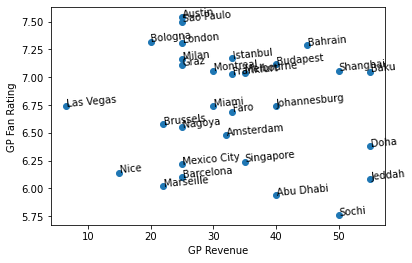

In [9]:
#Visualizing Plot cities on (x,y) where (fan rating, revenue)
fig, ax = plt.subplots()
ax.scatter(gprevenues, gpratings)

for i in range(n):
    ax.annotate(travelcities[i], (gprevenues[i], gpratings[i]), rotation=5)
plt.xlabel("GP Revenue")
plt.ylabel("GP Fan Rating")

plt.show()

### Part 2: Model Implementation - Selecting 21 Cities with Optimal Revenue & Fan Rating

In [10]:
#Select optimal cities
model = gp.Model("F1 City Selection")

x = model.addVars(n, vtype = GRB.BINARY, name = [travelcities[i] for i in range(n)])

model.addConstr(sum(x[i] for i in range(n)) == 21)

model.addConstr(sum(x[i]*gprevenues[i] for i in range(n)) >= 697)

model.addConstr(sum(x[i]*gpratings[i] for i in range(n)) >= 6.75*21)

model.setObjective(sum(x[i]*gprevenues[i]*gpratings[i] for i in range(n)) , GRB.MAXIMIZE)

model.optimize()

model.objval

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-17
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 30 columns and 90 nonzeros
Model fingerprint: 0x06c34453
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [4e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 7e+02]
Found heuristic solution: objective 4861.2800000
Presolve time: 0.01s
Presolved: 3 rows, 30 columns, 88 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)
Found heuristic solution: objective 5210.9200000

Root relaxation: objective 5.347380e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

5347.379999999999

In [11]:
#Retrieve cities
drop_cities = []
for v in model.getVars():
    if v.x == 0:
        drop_cities.append(str(v.varName))
        
selected_cities=[]
for v in model.getVars():
    if v.x == 1:
        selected_cities.append(str(v.varName))
        
drop_index = []
for i in drop_cities:
    if i in travelcities:
        drop_index.append(travelcities.index(i))

In [12]:
print("The 21 selected cities are: ")
for i in selected_cities:
    print(str(i))

The 21 selected cities are: 
Abu Dhabi
Amsterdam
Austin
Bahrain
Baku
Budapest
Doha
Faro
Frankfurt
Istanbul
Jeddah
Johannesburg
London
Melbourne
Miami
Milan
Montreal
Sao Paulo
Shanghai
Singapore
Sochi


### Part 3: Reshaping the Data for TSP

In [13]:
co2df_new=co2df
co2df_new = co2df_new.drop(columns = drop_cities, axis = 1)
co2df_new = co2df_new.reset_index()
co2df_new = co2df_new.iloc[:,1:30]
co2df_new = co2df_new.drop(drop_index)
co2array=np.array(co2df_new.iloc[:,1:])

In [14]:
travelcities_new = list(co2df_new.columns)
travelcities_new.remove("Cities")

In [15]:
#Data for Tour Specifications
n=len(travelcities_new)
N=[i for i in range(1,n)] #list of numbered cities
V=[0]+N #list of city indexes
A=[(i,j) for i in V for j in V if i!=j] #matrix of city-to-city arcs

In [16]:
co2dict={(i,j):round(co2array[i][j],2) for i,j in A if i!=j}
co2dictwnames={(i,j):round(co2array[travelcities_new.index(i)][travelcities_new.index(j)],2) for i in travelcities_new for j in travelcities_new if i!=j}

### Part 4: Model Implementation - Optimizing the Route for the 21 Cities

In [17]:
model = gp.Model("F1 City Tour")

X = model.addVars(n, n, vtype = GRB.BINARY, name = [str(i)+" to "+str(j) for i in travelcities_new for j in travelcities_new])
U = model.addVars(n, vtype = GRB.INTEGER, lb = 1, ub = n-1)

In [18]:
model.setObjective(sum(X[i,j]*co2dict[i,j]  for i,j in A), GRB.MINIMIZE)

In [19]:
for j in range(n):
    model.addConstr(sum(X[i,j] for i in range(n)) == 1)

for i in range(n):
    model.addConstr(sum(X[i,j] for j in range(n)) == 1)

# i != j
for i in range(n):
    model.addConstr(X[i,i] == 0)    

# Miller-Tucker-Zemlin (MTZ) Constraint to break subtours
for i in range(1,n):
    for j in range(1,n):
        model.addConstr(U[i] - U[j] + n*X[i,j] <= n-1)


In [20]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 463 rows, 462 columns and 2063 nonzeros
Model fingerprint: 0xe105aec1
Variable types: 0 continuous, 462 integer (441 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+05, 3e+07]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 41 rows and 22 columns
Presolve time: 0.01s
Presolved: 422 rows, 440 columns, 1980 nonzeros
Variable types: 0 continuous, 440 integer (420 binary)
Found heuristic solution: objective 1.430588e+08

Root relaxation: objective 4.522778e+07, 80 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4.5228e+07    0   41 1.4306e+08 4.5228e+07  68.4%     -    0s
H    0     0                    6.

In [21]:
for v in model.getVars():
    if v.x!=0:
        print(v.VarName, v.x)
        
print("Total emissions: ",model.objval," kg of CO2")

Abu Dhabi to Doha 1.0
Amsterdam to Frankfurt 1.0
Austin to Miami 1.0
Bahrain to Jeddah 1.0
Baku to Abu Dhabi 1.0
Budapest to Istanbul 1.0
Doha to Bahrain 1.0
Faro to London 1.0
Frankfurt to Milan 1.0
Istanbul to Sochi 1.0
Jeddah to Johannesburg 1.0
Johannesburg to Singapore 1.0
London to Amsterdam 1.0
Melbourne to Shanghai 1.0
Miami to Montreal 1.0
Milan to Budapest 1.0
Montreal to Sao Paulo 1.0
Sao Paulo to Faro 1.0
Shanghai to Austin 1.0
Singapore to Melbourne 1.0
Sochi to Baku 1.0
C441 1.0
C442 14.0
C443 8.0
C444 2.0
C445 20.0
C446 17.0
C447 1.0
C448 12.0
C449 15.0
C450 18.0
C451 3.0
C452 4.0
C453 13.0
C454 6.0
C455 9.0
C456 16.0
C457 10.0
C458 11.0
C459 7.0
C460 5.0
C461 19.0
Total emissions:  48609056.44  kg of CO2


### Part 5: Understanding the Solution

In [22]:
finalvalues = []
for v in model.getVars():
    if round(v.x) != 0:
        finalvalues.append(v.varName)
        
#Extract the city decision variables        
finalcityvalues=finalvalues[0:21]  

citypairs=[]

#Create a list of city pairings
for i in range(len(finalcityvalues)): 
    citypairs.append(finalcityvalues[i].split(" to "))

In [23]:
tour1=[]

#Ciy order
tour1.append(citypairs[0][1])

while tour1[-1]!="Abu Dhabi":
    cc=tour1[-1]
    for i in range(1,(len(citypairs))):
        if citypairs[i][0]==cc:
            tour1.append(citypairs[i][1])
            
tour1.pop()
tour1.insert(0, "Abu Dhabi")

In [24]:
l=len(tour1)

#Individual emissions from tour 1 legs
tour1co2sum=0
tour1co2list=[]
for i in range(0,l-1):
    c1=tour1[i]
    c2=tour1[i+1]
    tour1co2list.append(round(co2dictwnames[(c1,c2)]))
    tour1co2sum+=round(co2dictwnames[(c1,c2)])
tour1co2list.insert(0,"Start")
tour1co2sum=round((tour1co2sum/1000000),1)

#Revenue from tour 1
tour1revsum=0
tour1revlist=[]
for city in tour1:
    tour1revsum+=revenuedict[city]
    tour1revlist.append(revenuedict[city])

#Rating of tour 1
tour1ratsum=0
tour1ratlist=[]
for city in tour1:
    tour1ratsum+=ratingdict[city]
    tour1ratlist.append(ratingdict[city])
tour1rat=tour1ratsum/21

#Tour 1 by GP name
tour1gplist=[]
for city in tour1:
    tour1gplist.append(gpnamedict[city])

#Tour 1 Host Cities
tour1hostcities=[]
for city in tour1:
    tour1hostcities.append(hostcitiesdict[str(city)])

#Tour 1 Host Countries
tour1hostcountries=[]
for city in tour1:
    tour1hostcountries.append(hostcountriesdict[city])

In [25]:
#Visualizing the solution
tour1df=pd.DataFrame(list(zip(tour1hostcountries, tour1hostcities, tour1,tour1co2list, tour1revlist,tour1ratlist)), index=tour1gplist, columns=["Host Country", "Host City","Travel City", "Emissions From Leg (kg CO2)","Revenue from GP", "GP Rating"])
tour1df

,Host Country,Host City,Travel City,Emissions From Leg (kg CO2),Revenue from GP,GP Rating
Abu Dhabi Grand Prix,United Arab Emirates,Abu Dhabi,Abu Dhabi,Start,40.0,5.94
Qatar Grand Prix,Qatar,Doha,Doha,304877,55.0,6.38
Bahrain Grand Prix,Bahrain,Bahrain,Bahrain,0,45.0,7.29
Saudi Arabia Grand Prix,Saudi Arabia,Jeddah,Jeddah,764581,55.0,6.08
South African Grand Prix,South Africa,Johannesburg,Johannesburg,3069893,40.0,6.74
Singapore Grand Prix,Singapore,Singapore,Singapore,5986620,35.0,6.24
Australian Grand Prix,Australia,Melbourne,Melbourne,5428172,35.0,7.04
Chinese Grand Prix,China,Shanghai,Shanghai,7035373,50.0,7.06
United States Grand Prix,United States,Austin,Austin,7944202,25.0,7.54
Miami Grand Prix,United States,Miami,Miami,816899,30.0,6.74


In [26]:
#Final metrics
co2metric=round(((tour1co2sum-co22019)/co22019)*100,1)
if co2metric>0:
    co2improve="increase"
else:
    co2improve="decrease"
    
revmetric=round((((tour1revsum-rev2019)/rev2019)*100),1)
if revmetric>0:
    revimprove="increase"
else:
    revimprove="decrease"
    
ratmetric=round(((tour1rat-rat2019)/rat2019)*100,1)
if ratmetric>0:
    ratimprove="increase"
else:
    ratimprove="decrease"
    
    
print("There are "+str(l)+" races in this calendar.")

print("\nThe total amount of emissions generated from this calendar is "+str(tour1co2sum)+" million kg of CO2.")
print("This is a "+str(abs(co2metric))+"% "+co2improve+" from the 2019 calendar.")

print("\nThe total revenue generated from this calendar is $"+str(tour1revsum) +" million dollars USD.")
print("This is a "+str(abs(revmetric))+"% "+revimprove+" from the 2019 calendar.")

print("\nThe fan rating for this calendar is "+str(round(tour1rat,2))+".")
print("This is a "+str(abs(ratmetric))+"% "+ratimprove+" from the 2019 calendar.")

There are 21 races in this calendar.

The total amount of emissions generated from this calendar is 47.7 million kg of CO2.
This is a 58.7% decrease from the 2019 calendar.

The total revenue generated from this calendar is $791.0 million dollars USD.
This is a 16.5% increase from the 2019 calendar.

The fan rating for this calendar is 6.83.
This is a 1.1% increase from the 2019 calendar.


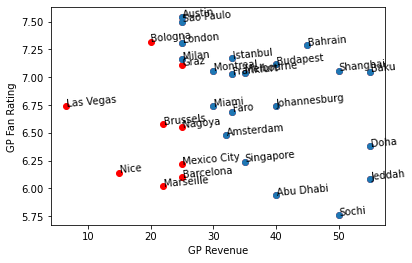

In [27]:
#Plot final cities on (x,y) where (fan rating, revenue)
fig, ax = plt.subplots()
ax.scatter(gprevenues, gpratings, color = 'red')

ax.scatter(tour1revlist,tour1ratlist)


for i in range(len(travelcities)):
    ax.annotate(travelcities[i], (gprevenues[i], gpratings[i]), rotation=5)
plt.xlabel("GP Revenue")
plt.ylabel("GP Fan Rating")

plt.show()